# Pull all data and fit on it - classify artists

In [1]:
import random
import math
seed = 231
random.seed(seed) # fix the datasets

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.utils.data import TensorDataset
from painting_loader import PaintingFolder

import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as T

import torchnet as tnt
from torchnet.meter import ConfusionMeter


import numpy as np
import timeit

%load_ext autoreload
%autoreload 2

dtype = torch.FloatTensor
ytype = torch.LongTensor
ytype_cuda = torch.cuda.LongTensor
if (torch.cuda.is_available()):
   dtype = torch.cuda.FloatTensor
print(ytype)
print(dtype)
print_every = 100

    
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

def train(model, loss_fn, optimizer, loader_train, loader_val, train_acc, val_acc, num_epochs = 1):
    train_loss_hist = []
    # val_loss_hist = []
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        for t, (x, y) in enumerate(loader_train):
            x_var = Variable(x.type(dtype))
            y_var = Variable(y.type(dtype).long())
            scores = model(x_var)
            loss = loss_fn(scores, y_var)
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss.data[0]))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        # record training loss history
        train_loss_hist.append(loss)
            
        # record training and validation accuracy at the end of each epoch
        train_acc.append(check_accuracy(model, loader_train))
        val_acc.append(check_accuracy(model, loader_val))
        
    return [train_acc, val_acc, train_loss_hist]
    
def check_accuracy(model, loader):
    print('Checking accuracy!')
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for x, y in loader:
        y = y.view(-1, 1).type(ytype)
        x_var = Variable(x.type(dtype), volatile=True)
        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
        
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return 100*acc

def confusion_matrix(model, loader, conf):
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for x, y in loader:
        y = y.view(-1, 1).type(ytype)
        x_var = Variable(x.type(dtype), volatile=True)
        scores = model(x_var)
        
        conf.add(scores.data, y)

<class 'torch.LongTensor'>
<class 'torch.cuda.FloatTensor'>


# Prep the data

In [3]:
## ALL MAIN ARGUMENTS FOR THE SCRIPT ##

dat_folder = '../data/'
img_folder = '../data/images/'
num_workers = 4

filter_subset = False # True if we want to filter to just train _1
balanced_dset = True # True if I want equal # of paintings per artist, false if I want to use all available per artist

## THIS VERSION OF SCRIPT HAS EQUAL NUMBER OF PAINTINGS PER ARTIST
num_train = 240
num_val = 30
num_test = 30
num_samples = num_train + num_val + num_test # threshold to include an artist
b_size = 60 # batch size for the data loaders


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageFilter
import random
import cv2
import os, glob

t = pd.read_csv(dat_folder + 'all_data_info.csv')

# filter down (if needed)
if (filter_subset):
    t = t[t['new_filename'].str.startswith('1')]
    t = t[t['in_train']]

t.head()
# print(t.shape)

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
1,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,75232.jpg
2,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,32145.jpg
3,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,20304.jpg
4,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,836.jpg


In [5]:
x = list(t['artist'].value_counts())
# print(len([a for a in x if a >= 500]))

# 37 artists with more than 400 paintings
# 57 with more than 300
# 108 with more than 200

In [6]:
# list of all artists to include
temp = t['artist'].value_counts()
threshold = num_samples
# threshold = 500
artists = temp[temp >= threshold].index.tolist()
num_artists = len(artists)

print(str(len(artists)) + ' artists being classified')

# pull train and val data for just those artists
train_dfs = []
val_dfs = []
test_dfs = []

for a in artists:
    df = t[t['artist'].str.startswith(a, na=False)].sample(n=num_samples, random_state=seed)
    t_df = df.sample(n=num_train, random_state=seed)
    rest_df = df.loc[~df.index.isin(t_df.index)]
    v_df = rest_df.sample(n=num_val, random_state=seed)
    te_df = rest_df.loc[~rest_df.index.isin(v_df.index)]
    
    train_dfs.append(t_df)
    val_dfs.append(v_df)
    test_dfs.append(te_df)

train_df = pd.concat(train_dfs)
val_df = pd.concat(val_dfs)
test_df = pd.concat(test_dfs)

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)
print("Done")

57 artists being classified
(13680, 12)
(1710, 12)
(1710, 12)
Done


In [7]:
mean_resnet = np.array([0.485, 0.456, 0.406])
std_resnet = np.array([0.229, 0.224, 0.225])
        
train_transform = T.Compose([
        T.RandomSizedCrop(224),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize(mean_resnet, std_resnet)
    ])
val_transform = T.Compose([
        T.Scale(256),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(mean_resnet, std_resnet)
    ])

train_dset = PaintingFolder(img_folder, train_transform, train_df)
loader_train = DataLoader(train_dset, batch_size=b_size, shuffle=True, num_workers=num_workers)
    
val_dset = PaintingFolder(img_folder, val_transform, val_df)
loader_val = DataLoader(val_dset, batch_size=b_size, shuffle=True, num_workers=num_workers)

test_dset = PaintingFolder(img_folder, val_transform, test_df)
loader_test = DataLoader(test_dset, batch_size=b_size, shuffle=True, num_workers=num_workers)

print("Done")

Done


# Simple network to use as a baseline

In [8]:
# Create a simple network to use as a baseline

simple_model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1), # -> 112
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(2), # -> 56
    nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1), # -> 28
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(2), # -> 14
    Flatten(),
    nn.Linear(6272, 4*num_artists),
    nn.ReLU(inplace=True),
    nn.Linear(4*num_artists, num_artists),
)

for m in simple_model.modules():
    if isinstance(m, nn.Conv2d):
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        m.weight.data.normal_(0, math.sqrt(2. / n))
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()
                
if torch.cuda.is_available():
    simple_model = simple_model.cuda()

simple_model.type(dtype)
loss_fn = nn.CrossEntropyLoss().type(dtype)

In [9]:
# Now we're going to feed a random batch into the model and make sure the output is the right size
x = torch.randn(64, 3, 224, 224).type(dtype)
x_var = Variable(x.type(dtype)) # Construct a PyTorch Variable out of your input data
ans = simple_model(x_var)        # Feed it through the model! 

# Check to make sure what comes out of your model
# is the right dimensionality... this should be True
# if you've done everything correctly
np.array_equal(np.array(ans.size()), np.array([64, num_artists]))

True

In [10]:
# apply my simple network to the dataset
reset(simple_model)

train_acc_simple = []
val_acc_simple = []
train_loss_simple = []

In [13]:
optimizer = optim.Adam(simple_model.parameters(), lr=1e-4)
train_acc_simple, val_acc_simple, train_loss_simple = train(simple_model, loss_fn, optimizer, loader_train, loader_val, train_acc_simple, val_acc_simple, num_epochs = 5)

Starting epoch 1 / 5
t = 100, loss = 1.8174
t = 200, loss = 2.4863
Checking accuracy!
Got 5684 / 13680 correct (41.55)
Checking accuracy!
Got 714 / 1710 correct (41.75)
Starting epoch 2 / 5
t = 100, loss = 2.1201
t = 200, loss = 2.2361
Checking accuracy!
Got 5713 / 13680 correct (41.76)
Checking accuracy!
Got 720 / 1710 correct (42.11)
Starting epoch 3 / 5
t = 100, loss = 2.3156
t = 200, loss = 2.3338
Checking accuracy!
Got 5838 / 13680 correct (42.68)
Checking accuracy!
Got 723 / 1710 correct (42.28)
Starting epoch 4 / 5
t = 100, loss = 1.9543
t = 200, loss = 2.1566
Checking accuracy!
Got 5826 / 13680 correct (42.59)
Checking accuracy!
Got 744 / 1710 correct (43.51)
Starting epoch 5 / 5
t = 100, loss = 2.2858
t = 200, loss = 1.8590
Checking accuracy!
Got 5861 / 13680 correct (42.84)
Checking accuracy!
Got 747 / 1710 correct (43.68)


## Training accuracy over time chart


[19.283625730994153, 24.86111111111111, 26.71783625730994, 29.912280701754383, 31.71783625730994, 33.14327485380117, 33.260233918128655, 35.15350877192983, 36.68859649122807, 34.76608187134503, 41.54970760233918, 41.76169590643275, 42.675438596491226, 42.58771929824562, 42.84356725146199]
[21.403508771929825, 24.853801169590643, 28.421052631578945, 31.69590643274854, 32.98245614035088, 34.26900584795322, 34.152046783625735, 35.67251461988304, 38.59649122807017, 35.67251461988304, 41.75438596491228, 42.10526315789473, 42.280701754385966, 43.50877192982456, 43.684210526315795]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


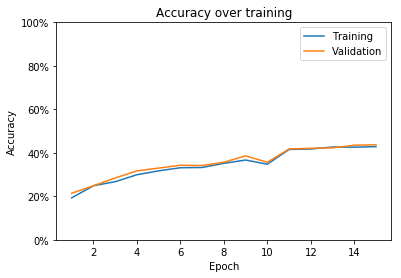

In [14]:
epochs = np.arange(len(train_acc_simple)) + 1
print(train_acc_simple)
print(val_acc_simple)
print(epochs)

# Plot the points using matplotlib
plt.plot(epochs, train_acc_simple)
plt.plot(epochs, val_acc_simple)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over training')
plt.legend(['Training', 'Validation'])

# y ticks
plt.gca().set_ylim(ymin=0, ymax=100)
vals = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in vals])

# x ticks
# vals = plt.gca().get_xticks()
# plt.gca().set_xticklabels(['{:0.0f}'.format(x) for x in vals])

plt.show()

In [15]:
torch.save(simple_model.state_dict(), 'resnet18-300paintings/run2/simplenet/state_dict.dat')
torch.save([train_acc_simple, val_acc_simple], 'resnet18-300paintings/run2/simplenet/train_val_accs.dat')

# ResNet-18 transfer learning

In [8]:
import torchvision 

# transfer learning on top of ResNet (only replacing final FC layer)
# model_conv = torchvision.models.resnet18(pretrained=True)
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, num_artists)

if torch.cuda.is_available():
    model_conv = model_conv.cuda()

loss_fn = nn.CrossEntropyLoss().type(dtype)

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=1e-3)

In [16]:
train_acc = []
val_acc = []

start_time = timeit.default_timer()
train_acc, val_acc, train_loss = train(model_conv, loss_fn, optimizer_conv, loader_train, loader_val, train_acc, val_acc, num_epochs = 5)

print()
print(str(timeit.default_timer() - start_time) + " seconds taken")

Starting epoch 1 / 5
t = 100, loss = 2.8211
t = 200, loss = 2.3959
Checking accuracy!
Got 6166 / 13680 correct (45.07)
Checking accuracy!
Got 785 / 1710 correct (45.91)
Starting epoch 2 / 5
t = 100, loss = 1.9377
t = 200, loss = 2.0781
Checking accuracy!
Got 6949 / 13680 correct (50.80)
Checking accuracy!
Got 891 / 1710 correct (52.11)
Starting epoch 3 / 5
t = 100, loss = 1.8665
t = 200, loss = 1.7152
Checking accuracy!
Got 7417 / 13680 correct (54.22)
Checking accuracy!
Got 967 / 1710 correct (56.55)
Starting epoch 4 / 5
t = 100, loss = 1.8097
t = 200, loss = 1.6175
Checking accuracy!
Got 7730 / 13680 correct (56.51)
Checking accuracy!
Got 953 / 1710 correct (55.73)
Starting epoch 5 / 5
t = 100, loss = 1.8972
t = 200, loss = 1.6587
Checking accuracy!
Got 7857 / 13680 correct (57.43)
Checking accuracy!
Got 981 / 1710 correct (57.37)

1788.5993661300001 seconds taken


In [23]:
# now we allow all of the network to change, but by less
for param in model_conv.parameters():
    param.requires_grad = True

optimizer_conv = optim.Adam(model_conv.parameters(), lr=1e-5)

start_time = timeit.default_timer()
train_acc, val_acc, train_loss = train(model_conv, loss_fn, optimizer_conv, loader_train, loader_val, train_acc, val_acc, num_epochs = 2)

print()
print(str(timeit.default_timer() - start_time) + " seconds taken")

Starting epoch 1 / 2
t = 100, loss = 0.7026
t = 200, loss = 0.5057
Checking accuracy!
Got 12315 / 13680 correct (90.02)
Checking accuracy!
Got 1330 / 1710 correct (77.78)
Starting epoch 2 / 2
t = 100, loss = 0.6567
t = 200, loss = 0.3863
Checking accuracy!
Got 12411 / 13680 correct (90.72)
Checking accuracy!
Got 1332 / 1710 correct (77.89)

699.9500909469998 seconds taken


In [10]:
check_accuracy(model_conv, loader_train)
check_accuracy(model_conv, loader_val)
check_accuracy(model_conv, loader_test)

Checking accuracy!
Got 12453 / 13680 correct (91.03)
Checking accuracy!
Got 1332 / 1710 correct (77.89)
Checking accuracy!
Got 1324 / 1710 correct (77.43)


77.42690058479532

In [11]:
print(train_acc)
print(val_acc)

# torch.save(model_conv.state_dict(), 'resnet18-300paintings/run2/state_dict.dat')
# torch.save([train_acc, val_acc], 'resnet18-300paintings/run2/train_val_accs.dat')


[45.07309941520467, 50.79678362573099, 54.21783625730994, 56.50584795321637, 57.43421052631579, 70.46783625730994, 76.17690058479532, 79.97076023391813, 82.58771929824562, 84.01315789473685, 85.29239766081871, 90.02192982456141, 90.72368421052632]
[45.90643274853801, 52.10526315789473, 56.54970760233918, 55.73099415204679, 57.36842105263158, 66.4327485380117, 70.87719298245614, 73.74269005847952, 74.61988304093568, 74.26900584795322, 73.9766081871345, 77.77777777777779, 77.89473684210526]


[45.07309941520467, 50.79678362573099, 54.21783625730994, 56.50584795321637, 57.43421052631579, 70.46783625730994, 76.17690058479532, 79.97076023391813, 82.58771929824562, 84.01315789473685, 85.29239766081871]
[45.90643274853801, 52.10526315789473, 56.54970760233918, 55.73099415204679, 57.36842105263158, 66.4327485380117, 70.87719298245614, 73.74269005847952, 74.61988304093568, 74.26900584795322, 73.9766081871345]
[ 1  2  3  4  5  6  7  8  9 10 11]


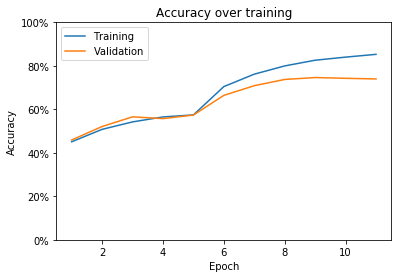

In [20]:
epochs = np.arange(len(train_acc)) + 1
print(train_acc)
print(val_acc)
print(epochs)

# Plot the points using matplotlib
plt.plot(epochs, train_acc)
plt.plot(epochs, val_acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over training')
plt.legend(['Training', 'Validation'])

# y ticks
plt.gca().set_ylim(ymin=0, ymax=100)
vals = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in vals])

# x ticks
# vals = plt.gca().get_xticks()
# plt.gca().set_xticklabels(['{:0.0f}'.format(x) for x in vals])

plt.show()

## Saliency maps of ResNet-18 images

In [27]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; Lo
    
    Tensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()
    
    # Wrap the input tensors in Variables
    X_var = Variable(X, requires_grad=True)
    y_var = Variable(y).type(ytype_cuda)
 
    scores = model(X_var)
    correct_scores = scores.gather(1, y_var.view(-1, 1)).squeeze()
    loss = torch.sum(correct_scores)
    
    loss.backward()
    
    gradient = torch.abs(X_var.grad.data)
    maxs, _ = torch.max(gradient, dim=1)
    saliency = maxs.squeeze()
    
    return saliency

def show_saliency_maps(dataset, model, numImages=4):
    """
    dataset should be a Dataset that we want to pull images from
    """
    
    model.eval()
    
    data_loader = DataLoader(dataset, batch_size=numImages, shuffle=True)
    
    X_tensor = None
    y_tensor = None
    for x, y in data_loader:
        X_tensor = x.type(dtype)
        y_tensor = y.view(-1, 1).type(ytype)
        X = X_tensor.cpu().numpy()
        y = y_tensor.cpu().numpy()[:,0]
        break

    # Compute saliency maps for images in X
    saliency = compute_saliency_maps(X_tensor, y_tensor, model)
    
    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.cpu().numpy()
    class_names = dataset.idx_to_class # TBD - class_to_idx from the DataSet
    
    N = numImages
    for i in range(N):
        plt.subplot(2, N, i + 1)
        img = X[i].transpose(1,2,0)
        
        img = img*std_resnet + mean_resnet
    
        plt.imshow(img)
        plt.axis('off')
        plt.title(class_names[y[i]])
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    plt.show()

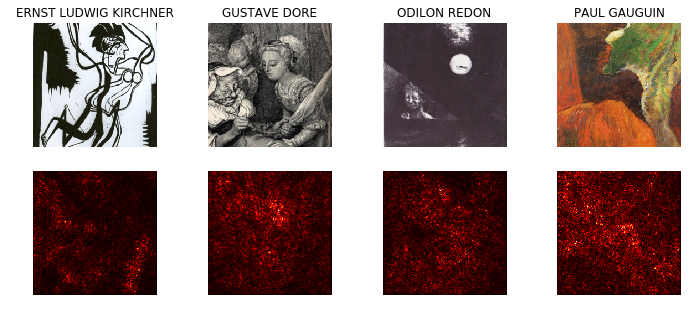

In [28]:
# before making the saliency map, set model as final so we don't calculate gradients for it
for param in model_conv.parameters():
    param.requires_grad = False
    
show_saliency_maps(train_dset, model_conv, numImages=4)

## Confusion Matrix

In [36]:
conf_test = ConfusionMeter(num_artists, normalized=False)
confusion_matrix(model_conv, loader_test, conf_test)

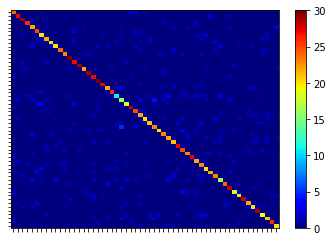

In [46]:
conf_arr = conf_test.value()

# from https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(conf_arr), cmap=plt.cm.jet, 
                interpolation='nearest', aspect ='auto')

width, height = conf_arr.shape


for x in np.arange(width):
    for y in np.arange(height):
        pass
        # ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
        #            horizontalalignment='center',
        #            verticalalignment='center')

cb = fig.colorbar(res)
alphabet = ''
plt.xticks(range(width), alphabet[:width])
plt.yticks(range(height), alphabet[:height])
plt.show()

## Precision and recall (using confusion matrix data)

In [51]:
true_positives = conf_arr.diagonal()

# precision for a class = (# of correct predictions for class) / all predictions of that class sum over column)
col_sums = np.sum(conf_arr, axis=0)
precision = true_positives / col_sums

# recall for a class = (# of correct predictions for class) / # of elements of that class (sum over row)
row_sums = np.sum(conf_arr, axis=1)
recall = true_positives / row_sums

F_score = 2*precision*recall/(precision+recall)

avg_Fscore = np.mean(F_score)
avg_precision = np.mean(precision)
avg_recall = np.mean(recall)

print(F_score.shape)
print(avg_Fscore)
print(avg_precision)
print(avg_recall)

(57,)
0.771777948131
0.777158745386
0.774269005848
[ 0.8         0.9         0.96666667  0.86666667  0.73333333  0.83333333
  0.66666667  0.73333333  0.66666667  0.66666667  0.8         0.76666667
  1.          0.9         0.96666667  0.73333333  0.96666667  0.9         1.
  0.9         0.73333333  0.86666667  0.36666667  0.53333333  0.6
  0.93333333  0.83333333  0.73333333  0.66666667  0.7         0.76666667
  0.66666667  0.76666667  0.73333333  0.7         0.9         0.83333333
  0.76666667  0.9         0.73333333  0.76666667  0.66666667  0.73333333
  0.76666667  0.53333333  0.8         0.93333333  0.6         0.66666667
  0.93333333  0.73333333  0.66666667  0.96666667  0.63333333  0.7
  0.86666667  0.66666667]


## Confusion matrix analysis

In [ ]:
# Map recall and precision values to the different artists
# look at artists with high/low recall, understand why this is the case

# for ones with low recall, look at where the confusion happened - what artists were they classified to instead?
# was low recall also true in the opposite direction, or just one way?

# for low precision, look at artists who seemed to get a lot of predictions (lots of work was labeled as theirs when it isn't)